In [182]:
from multiprocessing import Pool
from matplotlib.colors import LogNorm
from alignment_vmap import *
import numpy as np
from numpy.fft import fft, ifft

import jax
import time
from jax import vmap, grad, jit, random, lax
from jax import numpy as jnp
from jax.numpy.fft import fft as jfft, ifft as jifft
from util.logger import EventTracker
import matplotlib.pyplot as plt
from alignment_vmap import em_method, align_average, autocorr_fft, hessian_declarative, hessian_declarative_real
from alignment_vmap import align_average_and_project, align, invariants_from_data, bispectrum_inversion, manifold_iter
from itertools import product

[Array([-0.35971022+0.j       ,  0.68702775-0.5161946j,
        0.68702775+0.5161946j], dtype=complex64), Array([0.00212485+0.j        , 0.90980625-0.42508778j,
       0.90980625+0.4250876j ], dtype=complex64), Array([0.00212485+0.j        , 1.0124494 -0.25519618j,
       1.0124494 +0.25519598j], dtype=complex64), Array([0.00212485+0.j        , 1.0554595 -0.13702495j,
       1.0554595 +0.13702469j], dtype=complex64), Array([0.00212485+0.j        , 1.0667245 -0.07662892j,
       1.0667248 +0.07662867j], dtype=complex64), Array([0.00212485+0.j        , 1.0699863 -0.04473507j,
       1.0699863 +0.04473482j], dtype=complex64)]


(0.6425526738166809,
 1.2851053476333618,
 -0.10709210485219955,
 0.10709210485219955)

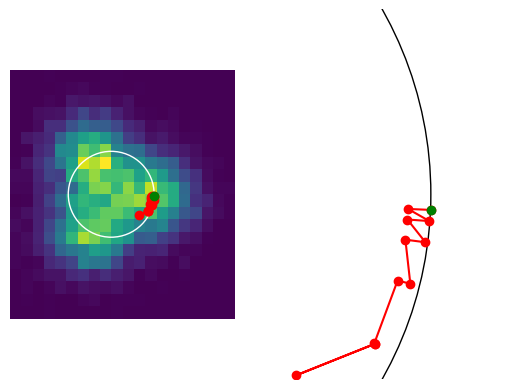

In [183]:
def get_signal(L):
    t = jnp.linspace(0, 2*np.pi, L+1)[:-1]
    #x = (t < np.pi).astype(float)
    x = 0 * t
    x = x.at[0].set(1.)
    x = x - 1/3
    #x = jnp.exp(jnp.sin(t))
    return t, x

def get_samples(key, x, noise_std, N):
    L = len(x)
    shiftkey, noisekey = jax.random.split(key, 2)
    shift = jax.random.randint(shiftkey, (N,), 0, L)
    noise = jax.random.normal(noisekey, (N, L)) * noise_std
    y = vmap(lambda s, z: jnp.roll(x + z, s), in_axes=(0, 0))(shift, noise)
    return y, noise, shift

MAXITER=5
def fix_point_iter(x0fft, yfft, acf_fft, mean, tol, maxiter, alpha=0.5, callback=None):
    res = tol + 1.
    i = 0
    xfft = x0fft
    while (res > tol) and i < maxiter:
        x_temp = (1 - alpha) * xfft + alpha * align_average(xfft, yfft)
        xfft_new = project_moments(x_temp, acf_fft, mean)
        res = relative_error(ifft(xfft), ifft(xfft_new))
        xfft = xfft_new
        i += 1
        if callback is not None:
            callback(xfft, x_temp, res, i)
    return xfft

def fpi_run(x0, y, noise_std):
    N, L = y.shape
    yfft = jfft(y, axis=1)
    y_auto_fft = jnp.clip(jnp.mean(autocorr_fft(yfft), axis=0) - noise_std**2 * L, 0, None) # mean of autocorrelation
    y_mean = jnp.mean(yfft[:, 0])  # Mean of means

    xtemplist = [jfft(x0)]
    xlist = [align_average_and_project(jfft(x0), yfft, y_auto_fft, y_mean)]    
    def callback(xfft, xtempfft, *args):
        xlist.append(xfft)
        xtemplist.append(xtempfft)
    
    fix_point_iter(jfft(x0), yfft, y_auto_fft, y_mean, alpha=1.0, tol=1e-6, maxiter=MAXITER, callback=callback)
    return xlist, xtemplist


N = int(1e4)
L = 3
stdev = 0.5 

t, x = get_signal(L)
y, noise, shift = get_samples(random.PRNGKey(4), x, stdev, N)
xfft = jfft(x)
yfft = jfft(y, axis=1)
ymean, yauto_fft, _ = invariants_from_data(y, stdev)
yabs_fft = yauto_fft**0.5

x_list, xtemplist = fpi_run(y[0], y, stdev)

#print(x_list, xtemplist)
#plt.plot(t, x, '*')
#plt.plot(t, jnp.real(jifft(x_list[-1])), '*') 

x_weaved = []
for x, y in zip(x_list, xtemplist):
    x_weaved.append(x)
    x_weaved.append(y)
rx = [float(x[1].real) for x in x_weaved]
ry = [float(x[1].imag) for x in x_weaved]

print(xtemplist)
    
plt.figure()

plt.subplot(121)
circle = plt.Circle((0, 0), abs(x_weaved[-1][1]), fill=False, color="white") 
#rx = [float(x[1].real/abs(x[1])) for x in x_weaved]
#ry = [float(x[1].imag/abs(x[1])) for x in x_weaved]
plt.plot(rx, ry, 'ro-', zorder=2)
plt.scatter([rx[-1]], [ry[-1]], c='g', zorder=3)
plt.gca().add_patch(circle)
r = abs(x_weaved[-1][1])
plt.xlim(-1.5*r, 1.5*r)
plt.ylim(-1.5*r, 1.5*r)
plt.axis("equal")
plt.axis("off")
#plt.scatter(yfft[:, 1].real, yfft[:, 1].imag, c='b', zorder=1, alpha=0.1)
plt.hist2d(yfft[:, 1].real, yfft[:, 1].imag, bins=20, cmap='viridis', zorder=-1)#, norm=LogNorm()

plt.subplot(122)
circle = plt.Circle((0, 0), abs(x_weaved[-1][1]), fill=False) 
#rx = [float(x[1].real/abs(x[1])) for x in x_weaved]
#ry = [float(x[1].imag/abs(x[1])) for x in x_weaved]
plt.plot(rx, ry, 'ro-', zorder=2)
plt.scatter([rx[-1]], [ry[-1]], c='g', zorder=3)
plt.gca().add_patch(circle)
r = abs(x_weaved[-1][1])
plt.axis("equal")
plt.xlim(0.6*r, 1.2*r)
plt.ylim(-0.1*r, 0.1*r)

plt.axis("off")


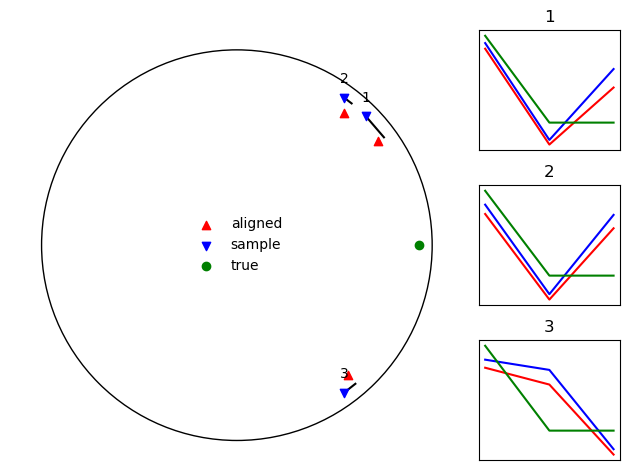

In [184]:
angles = [np.pi/4, np.pi*0.3, -np.pi*0.3]

ax = plt.subplot2grid((3, 4), (0, 0), 3, 3)
circle = plt.Circle((0, 0), abs(x_weaved[-1][1]), fill=False) 
#rx = [float(x[1].real/abs(x[1])) for x in x_weaved]
#ry = [float(x[1].imag/abs(x[1])) for x in x_weaved]
plt.gca().add_patch(circle)
plt.axis("equal")

t, x = get_signal(3)

for i, a in enumerate(angles):
    zfft = np.array([1/3, np.exp(1j*a), np.exp(-1j*a)])
    z_al = align_average(zfft, yfft)
    
    
    ax.plot([z_al[1].real/abs(z_al[1]), zfft[1].real/abs(zfft[1])], [z_al[1].imag/abs(z_al[1]), zfft[1].imag/abs(zfft[1])], 'k-', zorder=-1)
    ax.scatter([z_al[1].real/abs(zfft[1])], [z_al[1].imag/abs(zfft[1])], c='r', marker='^', label='aligned' if a == angles[0] else None)
    ax.scatter([zfft[1].real/abs(zfft[1])], [zfft[1].imag/abs(zfft[1])], c='b', marker='v', label='sample' if a == angles[0] else None)
    ax.text(zfft[1].real/abs(zfft[1]), zfft[1].imag/abs(zfft[1])+0.1, f"{i+1}", ha='center', va='center')
    
    plt.subplot2grid((3, 4), (i, 3), 1, 1)
    plt.title(f"{i+1}")
    plt.plot(jifft(zfft).real, 'b-')
    plt.plot(jifft(z_al).real, 'r-')
    plt.plot(x, 'g-')
    plt.yticks([])
    plt.xticks([])


ax.scatter([1], [0], c='g', marker='o', label='true')
ax.legend(frameon=False)
ax.axis("off")
plt.tight_layout()


    

(-1.5, 1.5)

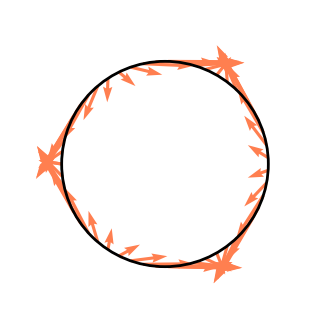

In [187]:
t = np.linspace(-np.pi, np.pi, 37+3*5)

xs = [np.array([1/3, np.exp(1j*a), np.exp(-1j*a)]) for a in t]
xs = [project_moments(x, yauto_fft, ymean) for x in xs]
grads = [x - align_average(x, yfft) for x in xs]



ptsx = [x[1].real/abs(x[1]) for x in xs]
ptsy = [x[1].imag/abs(x[1]) for x in xs]

gradsx = [x[1].real for x in grads]
gradsy = [x[1].imag for x in grads]

#rx = [float(x[1].real/abs(x[1])) for x in x_weaved]
#ry = [float(x[1].imag/abs(x[1])) for x in x_weaved]

plt.figure(figsize=(4,4))
circle = plt.Circle((0, 0), 1, fill=False, linewidth=2) 
plt.quiver(ptsx, ptsy, gradsx, gradsy, scale=1, color='coral', width=0.01)
plt.gca().add_patch(circle)
#plt.axis("equal")
plt.axis("off")
d = 1.5
plt.xlim(-d, d)
plt.ylim(-d, d)
#plt.tight_layout()


    